# Decision Trees

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

## Data

,X,Y,class
0,1,3.0,a
1,2,3.0,a
2,3,3.0,a
3,1,2.0,b
4,2,2.0,b
5,3,2.5,a
6,3,2.0,a
7,3,1.5,a
8,3,1.0,a


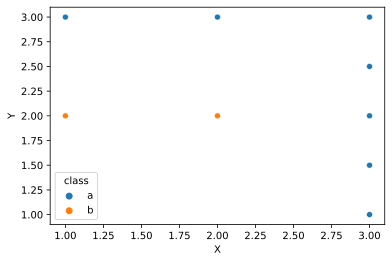

In [37]:
df=pd.DataFrame(data=[[1,3,'a'],[2,3,'a'],[3,3,'a'],[1,2,'b'],[2,2,'b'],[3,2.5,'a'],[3,2,'a'],[3,1.5,'a'],[3,1,'a']], columns=['X','Y','class'])
ax=sns.scatterplot(data=df,x='X',y='Y', hue='class');
df

## Homerolled decision tree solution, prefer scikitlearns solution below
First see if you should split<br>
calculate the gini impurity of current node<br>
if lower than any column split gini impurity then dont split<br>
Otherwise split on the column


Algorithm to calc gini impurity per column:
<ol>
    <li>Sort ascending</li>
    <li>Find midppoints between adjacent values</li>
    <li>Find gini impurity for that column</li>
    <li>Choose column with lowest impurity</li>
</ol>
    

In [92]:
def get_gi_node(df,target):
    '''
    get gini impurity for 1 node
    df: dataframe to operate on
    col: col to evaluate
    returns: gini impurity, total_number_values_in_this_node
    '''
    tot=len(df)
    df2=df.loc[:,f'{target}'].value_counts()
    # value_if_true if condition else value_if_false
    p=0
    for idx in df2.index:
        p=p + np.square(df2[idx]/tot)
    return (1-p, tot)

def find_mids(df,col):
    '''
    sort df on col, find all midpoints
    return as a list
    '''    
    #get a set of unique values, sorted
    vals= set((df.sort_values(by=f'{col}'))[col])

    
    #calculate the midpoints for above set of vals
    mids=[]
    start=None
    for v in vals:
        if start is not None:
            mids.append((v+start)/2)
        start=v
    return mids

def split_on_mid(df,col,mid):
    '''
    split df and return both parts as dataframes
    df: data frame
    col: to split on
    mid: midpoint val to split on
    return dflow,dfhigh
    '''
    return df[df[col] < mid], df[df[col] >= mid]

def get_gi_of_split(df,col,mid,target):
    '''
    gets weighted average of the gini impurities for the split
    df: data frame
    col: to split on
    mid: midpoint val to split on
    target: dependant variable (class name)
    returns gi for split
    '''
    df_low, df_high=split_on_mid(df,col,mid)
   
    gi_low, tot_low=get_gi_node(df_low,target)
    gi_high, tot_high=get_gi_node(df_high,target)
    tot_sum = tot_low + tot_high
    return (tot_low/tot_sum)*gi_low + (tot_high/tot_sum)*gi_high

def get_gi_of_column(df,col,target):
    '''
    gets best split point and the gini impurity for col
    df: data frame
    col: to split on
    target: dependant variable (class name)
    returns best gi and split point
    '''
    mids=find_mids(df,col)

    gi_all={}
    for mid in mids:
        gi_all[mid]=get_gi_of_split(df,col,mid,target)
    
    #get the lowest gini impurity
    split = min(gi_all, key=gi_all.get)
    return gi_all[split], split

def get_best_column_to_split_on(df,target):
    '''
    gets column with lowest gi
    df: data frame
    target: dependant variable (class name)
    returns bestcolumn, bestcolumngi, bestcolumnsp
    '''
    INVALID=1.1
    
    #get a list of columns
    cols=df.columns.tolist()

    #remove dependant variable column
    cols.remove(target)
    
    best_gi=INVALID
    best_split=None
    best_col=None
    for col in cols:
        gi,split= get_gi_of_column(df,col,target)
        if(gi<best_gi):
            best_gi=gi
            best_split=split
            best_col=col
    return  best_col, best_gi, best_split

### Recursive homerolled tree below
Split only if the gini impurity of a column split is less than the current nodes gini impurity

In [30]:
def do_tree(df,target):
    gi_this_node,_= get_gi_node(df,target)
    print(f'Current nodes gini impurity={gi_this_node} with {len(df)} members')

    #if pure node then return
    if(gi_this_node == 0.0):        
        return
    
    col,col_gi,col_split=get_best_column_to_split_on(df,'class')    
    if col_gi<gi_this_node:
        print(f'Splitting on column={col}, at split point={col_split} with gini impurity={col_gi}')
        df_low,df_high =split_on_mid(df,col,col_split)
        do_tree(df_low,target)
        do_tree(df_high,target)
    else:
        print(f'current node is final leaf')

In [31]:
do_tree(df,'class')

Current nodes gini impurity=0.345679012345679 with 9 members
Splitting on column=X, at split point=2.5 with gini impurity=0.2222222222222222
Current nodes gini impurity=0.5 with 4 members
Splitting on column=Y, at split point=2.5 with gini impurity=0.0
Current nodes gini impurity=0.0 with 2 members
Current nodes gini impurity=0.0 with 2 members
Current nodes gini impurity=0.0 with 5 members


## Better to use Scikitlearn Decision Tree
Much easier to setup, much more robust, works with categories as well as numbers

In [46]:
from sklearn import tree
df2=df.to_numpy();
clf = tree.DecisionTreeClassifier()
clf.fit(X=df2[:,:-1],y=df2[:,-1]);

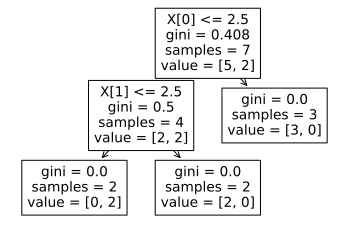

In [47]:
tree.plot_tree(clf);

In [25]:
# !conda install -c anaconda graphviz -y  #this one only installs the binaries, not the package
# !conda install python-graphviz -y  #use this one

'Synthetic.pdf'

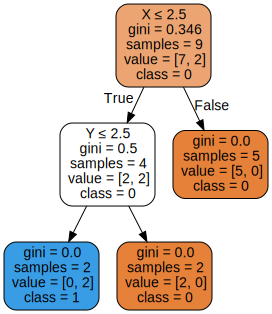

In [38]:
#just another way to look at the data
import graphviz
# dot_data = tree.export_graphviz(clf, out_file=None) 
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=['X','Y'],class_names=["0","1"],filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.render("Synthetic") 
graph

## Want to look at the decision boundaries?
Only works for 2 dimensions, sensitive to strings in target<br>
This function came from 'Python Machine Learning' by Sebastian Raschka

In [42]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, 
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')


In [64]:
#convert the 'a' and 'b' to 0's and 1s
mapper= {'a':0,'b':1}
func=lambda x: mapper[x]
vfunc = np.vectorize(func)
y1=vfunc(df2[:,-1])
y1

#refit the model using 0's and 1's for 'a's and 'b's
clf.fit(X=df2[:,:-1],y=y1);

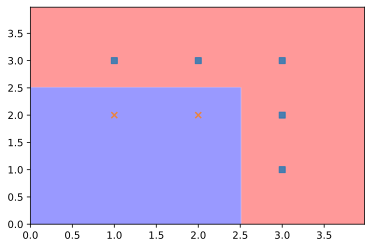

In [65]:
plot_decision_regions(X=df2[:,[0,1]],y=y1, classifier=clf, resolution=0.02)

## Now for a larger dataset

In [87]:
from sklearn import datasets
iris = datasets.load_iris()
dfi = pd.DataFrame(iris.data, columns=iris.feature_names)

mapper={v:i for v,i in enumerate(iris.target_names)}
def fun(x):
    return mapper[x]
vfunc=np.vectorize(fun)
dfi['target']=vfunc(iris.target)
dfi.head()
len(dfi)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


150

In [90]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X=iris.data[:,[0,1,2,3]],y=iris.target);

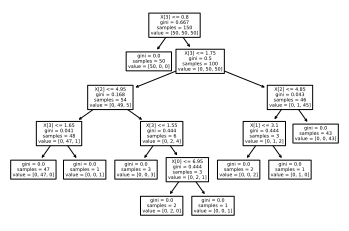

In [91]:
tree.plot_tree(clf);

### Want to plot the decision boundaries? Then need a tree that is trained on just 2 features since that is what plot_decision_regions expects

DecisionTreeClassifier()

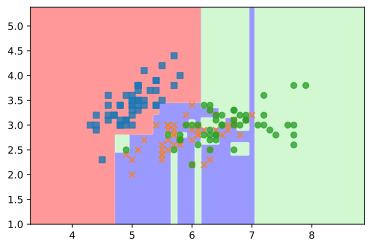

In [84]:
dfi = pd.DataFrame(iris.data, columns=iris.feature_names)
dfi['target']=iris.target
clf = tree.DecisionTreeClassifier()
clf.fit(X=iris.data[:,[0,1]],y=iris.target);
plot_decision_regions(X=iris.data[:,[0,1]], y=iris.target, classifier=clf, resolution=0.02)

## Graphics for presentation (82_decision_trees.pptx)

,X,Y,class
0,1,3,a
1,2,3,a
2,3,3,a
3,1,2,b
4,2,2,b
5,3,2,a
6,3,1,a


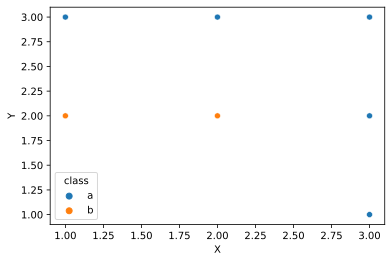

In [41]:
df2=pd.DataFrame(data=[[1,3,'a'],[2,3,'a'],[3,3,'a'],[1,2,'b'],[2,2,'b'],[3,2,'a'],[3,1,'a']], columns=['X','Y','class'])
ax=sns.scatterplot(data=df2,x='X',y='Y', hue='class')
df2